# Get DHV XC Data

In [48]:
import requests
import urllib
import pandas as pd

PAGE_SIZE = 500

places = {
    'Metzingen':11185,
    'Rammelsberg': 9427,
    'Estorf': 11001,
    'Leese': 10746,
    'Porta': 9712,
    'Lüdingen':9759,
    'Brunsberg': 9844,
    'Kella': 9521,
    'Börry': 9403,
    'Stapelburg': 9802
}

results = []
for place in ['Stapelburg','Rammelsberg']:
    limit = PAGE_SIZE
    for year in [2017,2018,2019,2020,2021,2022,2023,2024,2025]:
    #for year in [2024,2025]:
        query = {"navpars":{"start":0,"limit":PAGE_SIZE,"sort":[{"field":"FlightDate","dir":-1},{"field":"BestTaskPoints","dir":-1}]}}
        # for some reason, " is replaced by ' and spaces are added which is replaced by +
        decoded_url = f"https://de.dhv-xc.de/api/fli/flights?y={year}&fkcat%5B%5D=1&fkto%5B%5D={places[place]}&{urllib.parse.urlencode(query,quote_via=urllib.parse.quote_plus).replace('%27', '%22').replace('+', '')}"
        #print(decoded_url)
        r = requests.get(decoded_url)
        if r.status_code==200:
            response = r.json()
            df0 = pd.DataFrame(response['data'])
            #print(df0.columns.values)
            df0=df0[(df0['FirstLat'] > df0['LastLat']) & (df0['LastLat'] < '51.89')] # south of start
            results.extend(df0[[ 'LastName' ,'FlightDate', 'TakeoffWaypointName' , 'Glider' ,'FlightDuration', 'FirstLat','FirstLng','LastLat','LastLng','LandingLocation' ]].values)


df_results = pd.DataFrame(results,columns=[ 'LastName' ,'FlightDate','Takeoff', 'Glider' ,'Duration', 'FirstLat','FirstLng','LastLat','LastLng','LandingLocation' ])
df_results = df_results.astype(dtype= {"Duration":"int64"})
print(len(df_results))
df_results.sort_values(by='Duration').tail()

175


,LastName,FlightDate,Takeoff,Glider,Duration,FirstLat,FirstLng,LastLat,LastLng,LandingLocation
23,Salewski,2022-08-09,Airfield Stapelburg,Fusion S,16899,51.9134,10.6825,51.3901,9.77832,"Hann. Münden, Göttingen, Niedersachsen"
147,Eder,2024-05-10,Rammelsberg,CrossCountry2 M,17065,51.8903,10.431,51.7788,10.9773,"Blankenburg, Harz, Sachsen-Anhalt"
71,Görg,2019-05-05,Rammelsberg,Spectra - ML [CCC],18156,51.8903,10.4309,50.9189,12.1728,None
165,Görg,2025-05-09,Rammelsberg,LT 2 M,22451,51.8904,10.4311,51.4007,8.63753,"Brilon, Hochsauerlandkreis, Nordrhein-Westfalen"
94,Holle,2022-08-06,Rammelsberg,Camino M,25573,51.8902,10.4309,50.509,10.3031,"Rhönblick, Schmalkalden-Meiningen, Thüringen"


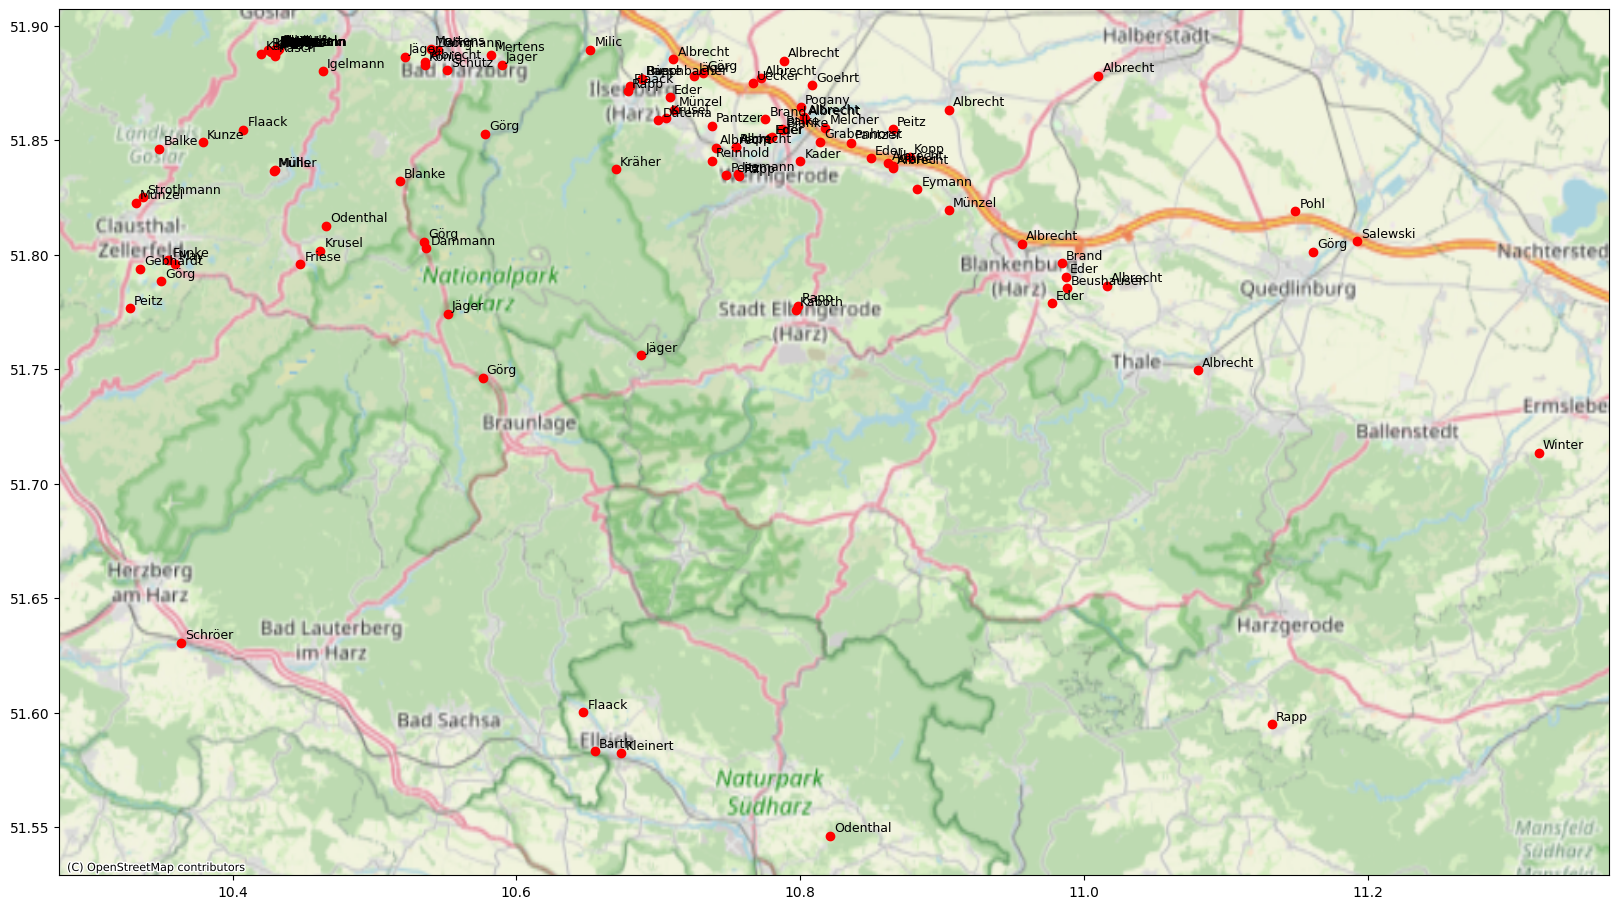

In [50]:
import geopandas as gpd
import contextily as cx


gdf = gpd.GeoDataFrame(
    df_results, geometry=gpd.points_from_xy(df_results.LastLng, df_results.LastLat), crs="EPSG:4326"
)
gdf = gpd.clip(gdf, mask=(10.3,51.5,11.5,51.9))

ax =gdf.plot(color="red", figsize=(20, 15))
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.LastName):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points",size=9)

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.DE)

